Jacob Masur and Daniel Cohen

Internet Access in Orleans Parish
===========================

## Introduction

This webpage \([https://jnmasur.github.io/index.html](https://jnmasur.github.io/index.html)\) was created by Jacob Masur and Daniel Cohen to investigate the distribution of internet access in Orleans Parish across geographic regions. We would like to answer the question: how accessible is wifi in different areas in Orleans Parish? Additionally, we want to find correlations between wifi access and demographic information such as income level, educational attainment, and ethnicity. It will also be interesting to investigate whether locations that provide access to free internet \(for example, public libraries\) are distributed in such a way that free internet access is optimized for those without access in their households. We predict that income level will have a significant impact on access to internet. In general, people with higher level of eduction also make more money and income is inequally distributed amongst different races, there will likely be a dependence on educational attainment and race.

## Collaboration Plan

We plan on meeting at least weekly to ensure that we collaborate enough on this project. We have set up a Jupyter notebook for which changes are being tracked and updated regularly in a public Github repository located at [https://github.com/jnmasur/jnmasur.github.io](https://github.com/jnmasur/jnmasur.github.io). The raw data, contained in a CSV file, and the text file that provides a full explanation of the data set is located in a subdirectory on our GitHub page. In general, we will be meeting in person to work on the project together. However, if the need arises, we will temporarily switch to Zoom meetings. Regardless of meeting schedule, we discuss what work needs to be accomplished, what is working well, and what we might need to rethink every few days to ensure that we are maintaining consistent progress.

## Data Overview

For our investigation, we will be using five distinct data sets. The first one contains census tract level information reagrding the type and precense of internet and computers by household for census tracts across the entire country and is provided by [NHGIS](https://www.nhgis.org/). We also obtained 3 other data sets from NHGIS, one providing the racial makeup by census tract, one detailing educational attainment for people 25 years of age or older by census tract, and one containing the median household income also by census tract. This data is the result of the [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-5year.html) which is conducted by the Census Bureau and is therefore a highly accurate survey from a trustworthy source. All datasets sourced from NHGIS contain country-wide data, and most contain many variables that are irrelevant to our discussion, so cleaning these sets is essential. The final data set contains geographic information for locations with free publicly accessible internet in Orleans Parish. This data comes from the [official New Orleans Database](https://data.nola.gov/) which is also a very trustworthy source. All data sets come from official government sources, so we believe that this data is accurate and will provide a good representation of internet access by race, income, and educational attainment.

## NHGIS Internet Data

The first data sets we will consider is sourced from NHGIS, it contains census tract data on the type of computers and the precense and types of internet subscriptions in households for the entire country. This data frame is therefore extremely large.

In [1]:
# useful libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
import rtree

In [2]:
# load the internet access data set
internet = pd.read_csv("./data/internet_data.csv")
internet.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AIQBM004,AIQBM005,AIQBM006,AIQBM007,AIQBM008,AIQBM009,AIQBM010,AIQBM011,AIQBM012,AIQBM013
0,G0100010020100,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,71,69,36,75,61,30,8,11,8,50
1,G0100010020200,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,85,80,52,85,51,20,10,11,24,82
2,G0100010020300,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,129,107,81,129,86,57,17,11,14,108
3,G0100010020400,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,160,142,78,158,107,61,11,11,25,126
4,G0100010020500,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,372,362,174,434,200,92,45,16,148,183


Source:  
Steven Manson, Jonathan Schroeder, David Van Riper, Tracy Kugler, and Steven Ruggles.  
IPUMS National Historical Geographic Information System: Version 16.0  
2017 American Community Survey: 5-Year Data \[2013-2017, Tracts & Larger Areas\]. Minneapolis, MN: IPUMS. 2021.  
[http://doi.org/10.18128/D050.V16.0](http://doi.org/10.18128/D050.V16.0)

### Cleaning the Data Set

The data set at this point contains a lot of data that is irrelevant to our investigation; we will therefore need to clean the data set, so that it becomes usable. Since we are only interested in Orleans Parish data, we filter the dataset accordingly.

In [3]:
internet = internet[(internet["STATE"] == "Louisiana") & (internet["COUNTY"] == "Orleans Parish")]
internet.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AIQBM004,AIQBM005,AIQBM006,AIQBM007,AIQBM008,AIQBM009,AIQBM010,AIQBM011,AIQBM012,AIQBM013
28917,G2200710000100,2013-2017,NaN,NaN,Louisiana,22,Orleans Parish,71,NaN,NaN,...,155,144,75,145,129,79,12,12,34,87
28918,G2200710000200,2013-2017,NaN,NaN,Louisiana,22,Orleans Parish,71,NaN,NaN,...,79,42,11,79,72,6,12,12,45,47
28919,G2200710000300,2013-2017,NaN,NaN,Louisiana,22,Orleans Parish,71,NaN,NaN,...,56,51,41,46,33,15,9,12,10,68
28920,G2200710000400,2013-2017,NaN,NaN,Louisiana,22,Orleans Parish,71,NaN,NaN,...,80,61,43,62,61,34,29,12,38,84
28921,G2200710000601,2013-2017,NaN,NaN,Louisiana,22,Orleans Parish,71,NaN,NaN,...,43,34,9,43,31,7,12,12,14,71


There is still much extraneous data contained in this table, and we certainly will not be able to investigate 84 variables. In the next cell, we reduce our consideration to 3 variables: the census tract, the total households surveyed, the number of households without internet access.

In [74]:
df_internet = internet[["TRACTA", "AIQAE001", "AIQBE013"]]

The definition of these columns can be found in the data folder on our github. Here we rename the columns according to their definitions, so the column labels provide useful information.

In [75]:
df_internet = df_internet.rename(columns={"TRACTA": "Census Tract", "AIQAE001":"Total", "AIQBE013":"No Internet"})

For future analysis, it is also useful to have the number of households with internet access, so we calculate this by subtracting the number of households without internet access from the number of households with internet access.

In [76]:
df_internet["Has Internet"] = df_internet["Total"] - df_internet["No Internet"]

Now, since each observation in the data frame is a census tract, this value is unique, and works well as an index.

In [77]:
df_internet.set_index("Census Tract", inplace=True)

Some census tracts contain no data, we would like to remove these so we filter out any row in which the total households surveyed is 0.

In [78]:
df_internet = df_internet[df_internet["Total"] > 0]

In [79]:
df_internet

,Total,No Internet,Has Internet
Census Tract,,,
100,1404,204,1200
200,487,192,295
300,525,315,210
400,854,408,446
601,384,305,79
...,...,...,...
14000,935,610,325
14100,1008,296,712
14200,909,218,691


At this point, data across census tracts is difficult to compare since the total households vary significantly. Therefore, we find the proportion of households with the property described by each variable.

In [80]:
internet_proportions = df_internet.drop(columns=["Total"]).divide(df_internet["Total"], axis=0)
internet_proportions

,No Internet,Has Internet
Census Tract,,
100,0.145299,0.854701
200,0.394251,0.605749
300,0.600000,0.400000
400,0.477752,0.522248
601,0.794271,0.205729
...,...,...
14000,0.652406,0.347594
14100,0.293651,0.706349
14200,0.239824,0.760176


## Publicly Accessible Internet
There are some locations throughout Orleans Parish that provide free access to internet for the public. It will be interesting to investigate the location of these relative to census tracts, especially those in which a small proportion of the population has access to the internet.

In [138]:
free = pd.read_csv("./data/ComputerResources_data.csv")

In [139]:
free

,the_geom,ObjectID,Location,Address,Zip Code,Phone,Hours,Sunday Hours,Computers,Kids PC Area,...,WiFi,Printing,Support Available,Support Type,Restrictions,Device Rental Program,Device Rental Type,Device Rental Requirements,Device Rental Restrictions,Classes Available
0,POINT (-90.101872057386 29.97491327785),7,Mid-City Branch,4140 Canal Street,70119,(504) 596-2654,"10 a.m. - 8 p.m., Mon.- Thurs.\n10 a.m. - 5 p....",No,12.0,No,...,Yes,Yes,Yes,Limited,NaN,Yes,iPad,18+,In-House Only,None
1,POINT (-90.013800108486 29.966383690636),6,Martin Luther King Branch,1611 Caffin Avenue,70117,(504) 596-2695,"10 a.m. - 8 p.m., Mon. - Thurs.\n10 a.m. - 5 p...",No,12.0,No,...,Yes,Yes,Yes,Partial,NaN,Yes,iPad,18+,In-House Only,Basic Computing
2,POINT (-90.013637780585 29.922729858452),9,Algiers Regional Branch,3014 Holiday Drive,70131,(504) 596-2641,"10 a.m. - 8 p.m., Mon.- Thurs.\n10 a.m. - 5 p....",Yes,46.0,Yes,...,Yes,Yes,Yes,Full-Time,NaN,Yes,iPad,18+,In-House Only,None
3,POINT (-90.101057739914 29.921354322638),2,Children's Resource Center,913 Napoleon Avenue,70115,(504) 596-2628,"10 a.m. – 8 p.m., Mon. - Thu.\n10 a.m. - 5 p.m...",No,5.0,No,...,Yes,Yes,Yes,As Needed,NaN,Yes,iPad,18+,In-House Only,None
4,POINT (-90.107558120658 30.004961193384),14,Robert E. Smith Branch,6301 Canal Blvd,70124,(504) 596-2638,10 a.m. - 8 p.m Mon-Thurs. \n10 a.m. - 5 p.m F...,Yes,21.0,Yes,...,Yes,Yes,Yes,Full-Time,NaN,Yes,iPad,18+,In-House Only,None
5,POINT (-90.036747168024 29.963914263523),3,Alvar Branch,913 Alvar Street,70117,(504) 596-2667,"10 a.m. - 8 p.m., Mon. - Thurs.\n10 a.m. - 5 p...",No,14.0,Yes,...,Yes,Yes,Yes,As Needed,NaN,Yes,iPad,18+,In-House Only,None
6,POINT (-89.972060187576 30.032258802137),10,New Orleans East Regional Branch,5641 Read Blvd.,70127,(504) 596-0200,"10 a.m. - 8 p.m., Mon. - Thurs.\n10 a.m. - 5 p...",Yes,45.0,Yes,...,Yes,Yes,Yes,Full-Time,NaN,Yes,iPad,18+,In-House Only,Basic Computing
7,POINT (-90.127869185693 29.948652362038),8,Nix Branch,1401 S. Carrollton Avenue,70118,(504) 596-2630,"10 a.m - 8 p.m., Mon. - Thurs.\n10 a.m. - 5 p....",No,6.0,No,...,Yes,Yes,Yes,Limited,NaN,Yes,iPad,18+,In-House Only,None
8,POINT (-90.110248239452 29.926647086628),5,Milton H. Memorial Latter Branch,5120 St. Charles Avenue,70115,(504) 596-2625,"10a.m. - 8 p.m., Mon. - Thurs.\n10 a.m. - 5 p....",Yes,6.0,No,...,Yes,Yes,Yes,Full-Time,Closed Due to Renovations,Yes,iPad,18+,In-House Only,None
9,POINT (-90.079215131633 29.96620226909),16,Sojourner Truth,2200 Lafitte St,70119,(504) 827-9963,8 am to 7 pm Mon -Fri. \n9 am to 1 pm Saturdays,No,20.0,No,...,Yes,Must bring flash drive (not self-service),Yes,As Needed,Unattended teens must be 12+,No,No,No,No,Basic Computing and Resume Building


Source:  
City of New Orleans Open Data.  
[https://data.nola.gov/Health-Education-and-Social-Services/ComputerResources/vaaq-p3ar](https://data.nola.gov/Health-Education-and-Social-Services/ComputerResources/vaaq-p3ar).

We would only like the locations that provide access to internet, so we filter out all the ones that do not. Additionally, we only are interested in the location of these public internet resources.

In [140]:
free = free[free["Internet"] == "Yes"]
# obtain the latitude and longitude using a regex
free = free["the_geom"].str.extract(r"(-\d{2}\.\d+)\w\s(\d{2}\.\d+)")
free

,0,1
0,-90.10187205738,29.97491327785
1,-90.01380010848,29.966383690636
2,-90.01363778058,29.922729858452
3,-90.10105773991,29.921354322638
4,-90.10755812065,30.004961193384
5,-90.03674716802,29.963914263523
6,-89.97206018757,30.032258802137
7,-90.12786918569,29.948652362038
8,-90.11024823945,29.926647086628
9,-90.07921513163,29.96620226909


In [141]:
# free.apply(lambda row: Point(row[1], row[2]), axis=1)
free["lon"] = pd.to_numeric(free[0])
free["lat"] = pd.to_numeric(free[1])
free = free.drop(columns=[0,1])

In [158]:
geo_free = gpd.GeoDataFrame(free)

In [159]:
geo_free["geom"] = geo_free.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
geo_free = geo_free.set_geometry("geom")
geo_free

,lon,lat,geom
0,-90.101872,29.974913,POINT (-90.10187 29.97491)
1,-90.013800,29.966384,POINT (-90.01380 29.96638)
2,-90.013638,29.922730,POINT (-90.01364 29.92273)
3,-90.101058,29.921354,POINT (-90.10106 29.92135)
4,-90.107558,30.004961,POINT (-90.10756 30.00496)
5,-90.036747,29.963914,POINT (-90.03675 29.96391)
6,-89.972060,30.032259,POINT (-89.97206 30.03226)
7,-90.127869,29.948652,POINT (-90.12787 29.94865)
8,-90.110248,29.926647,POINT (-90.11025 29.92665)
9,-90.079215,29.966202,POINT (-90.07922 29.96620)


## Race, Income, and Education Data

The goal for our project is to compare internet access in households to the racial makeup, income, and educational attainment by census tract. In order to do this, we load another data set sourced from NHGIS which contains information for the racial makeup of each census tract, the educational attainment for residents 25 years of age or older by census tract, and the median household income by census tract.

In [14]:
rci = pd.read_csv("./data/race_education_income.csv", encoding="ISO-8859-1")
rci.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AH04E017,AH04E018,AH04E019,AH04E020,AH04E021,AH04E022,AH04E023,AH04E024,AH04E025,AH1PE001
0,G0100010020100,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,282,88,34,184,77,261,142,45,28,67826.0
1,G0100010020200,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,495,90,91,182,106,166,51,16,5,41287.0
2,G0100010020300,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,724,114,161,446,146,232,150,20,19,46806.0
3,G0100010020400,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,873,208,249,291,250,540,156,38,57,55895.0
4,G0100010020500,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,1331,264,439,1033,587,1446,1037,197,87,68143.0


Source:  
Steven Manson, Jonathan Schroeder, David Van Riper, Tracy Kugler, and Steven Ruggles.  
IPUMS National Historical Geographic Information System: Version 16.0  
2017 American Community Survey: 5-Year Data \[2013-2017, Tracts & Larger Areas\]. Minneapolis, MN: IPUMS. 2021.  
[http://doi.org/10.18128/D050.V16.0](http://doi.org/10.18128/D050.V16.0)

Again, this data set contains country-wide data, and we would like to restrict our consideration to Orleans Parish.

In [15]:
# filter out everywhere besides orleans parish
rci = rci[(rci["STATE"] == "Louisiana") & (rci["COUNTY"] == "Orleans Parish")]

### Race Dataset
We would like to separate this large data set into three different data sets for race, income, and educational attainment. For the race data set, we select census tract and all the race information collected in the survey. Once again, the definition of the variables is located in the data folder on github, so we rename the columns to useful labels.

In [70]:
race = rci[["TRACTA", "AHY2E001", "AHY2E002", "AHY2E003", "AHY2E004", "AHY2E005", "AHY2E006", "AHY2E007", 
            "AHY2E008"]]
race = race.rename(columns={"TRACTA":"Census Tract", "AHY2E001":"Total", "AHY2E002":"White", "AHY2E003":"Black", 
                            "AHY2E004":"Native American", "AHY2E005":"Asian", "AHY2E006":"Pacific Islander", 
                            "AHY2E007":"Other", "AHY2E008":">= 2 Races"})
race.set_index("Census Tract", inplace=True)
race = race[race["Total"] > 0]

For the purposes of our study, it is more informatative to consider fewer variables, and therefore we will only consider the white population and the non-white population.

In [71]:
race["Non-White"] = race[["Black", "Native American", "Asian", "Pacific Islander", "Other", 
                          ">= 2 Races"]].sum(axis=1)

In [72]:
race = race.drop(columns=["Black", "Native American", "Asian", "Pacific Islander", "Other", ">= 2 Races"])
race

,Total,White,Non-White
Census Tract,,,
100,2811,2574,237
200,1513,206,1307
300,1228,127,1101
400,2034,311,1723
601,1037,28,1009
...,...,...,...
14200,1718,1250,468
14300,2192,307,1885
14400,1619,1093,526


It will be easier to compare observations if we obtain the proportion of each race by census tract which we do below.

In [73]:
race_proportions = race.drop(columns=["Total"]).divide(race["Total"], axis=0)
race_proportions

,White,Non-White
Census Tract,,
100,0.915688,0.084312
200,0.136153,0.863847
300,0.103420,0.896580
400,0.152901,0.847099
601,0.027001,0.972999
...,...,...
14200,0.727590,0.272410
14300,0.140055,0.859945
14400,0.675108,0.324892


### Education Dataset
Now, we create a new data frame containing all information regarding educational attainment by census tract.

In [66]:
education = rci[["TRACTA", "AH04E001", "AH04E002", "AH04E003", "AH04E004", "AH04E005", "AH04E006", "AH04E007",
                 "AH04E008", "AH04E009", "AH04E010", "AH04E011", "AH04E012", "AH04E013", "AH04E014", "AH04E015",
                 "AH04E016", "AH04E017", "AH04E018", "AH04E019", "AH04E020", "AH04E021", "AH04E022", "AH04E023",
                 "AH04E024", "AH04E025"]].copy()

The education data set contains a lot of information that is not particularly useful. For example, there are variables for completion of each grade up to $12^{\text{th}}$ which we group into no high school education. We group all information into 2 columns, the population who did not complete high school, and the population that did complete high school.

In [67]:
# group all variables corresponding to an incomplete high school education
education["No High School"] = education[["AH04E002", "AH04E003", "AH04E004", "AH04E005", "AH04E006", "AH04E007", 
                                         "AH04E008", "AH04E009", "AH04E010", "AH04E011", "AH04E012", "AH04E013", 
                                         "AH04E014", "AH04E015", "AH04E016"]].sum(axis=1)
# group all variables corresponding to a high school degree, GED, or above
education["High School or Above"] = education[["AH04E017", "AH04E018", "AH04E019", "AH04E020", "AH04E021",
                                              "AH04E022", "AH04E023", "AH04E024", "AH04E025"]].sum(axis=1)
# drop all columns that we have grouped
education = education.drop(columns=["AH04E002", "AH04E003", "AH04E004", "AH04E005", "AH04E006", "AH04E007", 
                                    "AH04E008", "AH04E009", "AH04E010", "AH04E011", "AH04E012", "AH04E013", 
                                    "AH04E014", "AH04E015", "AH04E016", "AH04E017", "AH04E018", "AH04E019", 
                                    "AH04E020", "AH04E021", "AH04E022", "AH04E023", "AH04E024", "AH04E025"])
education = education.rename(columns={"TRACTA":"Census Tract", "AH04E001":"Total"})
education.set_index("Census Tract", inplace=True)

Again, there are census tracts that do not contain any information, so we filter out any row with zero total people surveyed.

In [68]:
education = education[education["Total"] > 0]
education

,Total,No High School,High School or Above
Census Tract,,,
100,2278,65,2213
200,1070,298,772
300,949,120,829
400,1424,280,1144
601,691,351,340
...,...,...,...
14200,1542,166,1376
14300,1138,374,764
14400,1356,134,1222


In order to facilitate easier comparisons between census tracts, we obtain the proportions of each tract with no high school education and a high school education or more schooling.

In [69]:
education_proportions = education.drop(columns=["Total"]).divide(education["Total"], axis=0)
education_proportions

,No High School,High School or Above
Census Tract,,
100,0.028534,0.971466
200,0.278505,0.721495
300,0.126449,0.873551
400,0.196629,0.803371
601,0.507959,0.492041
...,...,...
14200,0.107652,0.892348
14300,0.328647,0.671353
14400,0.098820,0.901180


### Income Dataset
The income dataset contains very little information, it simply contains the the census tract number and the median household income for that census tract. The only cleaning we must perform on this dataframe is the removal of census tracts with no income information.

In [64]:
income = rci[["TRACTA","AH1PE001"]]

In [65]:
income = income.dropna()
income = income.rename(columns={"TRACTA":"Census Tract","AH1PE001":"Median Household Income"})
income.set_index("Census Tract", inplace=True)
income

,Median Household Income
Census Tract,
100,70292.0
200,32467.0
300,26116.0
400,25565.0
601,13145.0
...,...
14000,11307.0
14100,19608.0
14200,51510.0


### Population Dataset
The population dataset is also the result of the American Community Surveyed and was obtained via [NHGIS](https://data2.nhgis.org/main). The only relevant information in the population dataset is the tract number and the total population of the tract. Therefore, we remove all tracts that do not correspond to Orleans Parish and only select the relevant columns.

In [183]:
pop = pd.read_csv("./data/population.csv", encoding="ISO-8859-1")

In [184]:
pop = pop[(pop["STATE"] == "Louisiana") & (pop["COUNTY"] == "Orleans Parish")]

In [185]:
pop = pop[["TRACTA", "AHY1E001", "GISJOIN"]].rename(columns={"AHY1E001":"Population", 
                                                             "TRACTA":"Tract"}).set_index("Tract")

In [195]:
pop = pop[pop["Population"] > 0]
pop.head()

,Population,GISJOIN,standard_tract
Tract,,,
100,2811,G2200710000100,100
200,1513,G2200710000200,200
300,1228,G2200710000300,300
400,2034,G2200710000400,400
601,1037,G2200710000601,601


## Geographic Data

In order to perform mapping of the census tracts, we require a shape file which gives the geometry of each census tract. This file is sourced from **FILL THIS OUT LATER**. 

In [165]:
tracts = gpd.read_file("~/Desktop/shapefiles/shapefiles/tl_2021_22_tract.shp")
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,22,101,040900,22101040900,409,Census Tract 409,G5020,S,409722770,760668664,+29.5608138,-091.4619429,"POLYGON ((-91.68577 29.61712, -91.65101 29.686..."
1,22,101,990000,22101990000,9900,Census Tract 9900,G5020,S,0,189391417,+29.3628101,-091.4881338,"POLYGON ((-91.59139 29.37522, -91.59137 29.405..."
2,22,113,950500,22113950500,9505,Census Tract 9505,G5020,S,246436007,1661026,+29.9389966,-092.2111299,"POLYGON ((-92.30722 29.85336, -92.30721 29.853..."
3,22,113,951100,22113951100,9511,Census Tract 9511,G5020,S,1431316623,636785094,+29.6827320,-092.3238840,"POLYGON ((-92.61608 29.59280, -92.61608 29.595..."
4,22,113,950600,22113950600,9506,Census Tract 9506,G5020,S,35884151,518880,+30.0163564,-092.1181212,"POLYGON ((-92.17043 29.97538, -92.16991 29.976..."


In [154]:
# get census tracts for orleans parish
optracts = tracts[tracts.COUNTYFP == "071"]

In [180]:
optracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,standard_tract
120,22,071,980000,22071980000,9800,Census Tract 9800,G5020,S,4961157,712738,+30.0014023,-090.0938133,"POLYGON ((-90.10255 29.98559, -90.10245 29.986...",80000
142,22,071,980100,22071980100,9801,Census Tract 9801,G5020,S,31183156,11853446,+30.0073168,-089.9136473,"POLYGON ((-90.02215 29.99277, -90.02036 29.993...",80100
143,22,071,001751,22071001751,17.51,Census Tract 17.51,G5020,S,42200749,4725188,+30.0292981,-089.9106110,"POLYGON ((-90.02702 30.00837, -90.02652 30.008...",1751
144,22,071,990000,22071990000,9900,Census Tract 9900,G5020,S,0,323404209,+30.1214413,-089.9729100,"POLYGON ((-90.11937 30.03664, -90.11103 30.135...",90000
145,22,071,001744,22071001744,17.44,Census Tract 17.44,G5020,S,1316509,0,+30.0364871,-089.9866610,"POLYGON ((-89.99692 30.03563, -89.99665 30.035...",1744


In [169]:
optracts["standard_tract"] = optracts["GEOID"].str[-5:].astype(np.int64)
optracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,standard_tract
120,22,071,980000,22071980000,9800,Census Tract 9800,G5020,S,4961157,712738,+30.0014023,-090.0938133,"POLYGON ((-90.10255 29.98559, -90.10245 29.986...",80000
142,22,071,980100,22071980100,9801,Census Tract 9801,G5020,S,31183156,11853446,+30.0073168,-089.9136473,"POLYGON ((-90.02215 29.99277, -90.02036 29.993...",80100
143,22,071,001751,22071001751,17.51,Census Tract 17.51,G5020,S,42200749,4725188,+30.0292981,-089.9106110,"POLYGON ((-90.02702 30.00837, -90.02652 30.008...",1751
144,22,071,990000,22071990000,9900,Census Tract 9900,G5020,S,0,323404209,+30.1214413,-089.9729100,"POLYGON ((-90.11937 30.03664, -90.11103 30.135...",90000
145,22,071,001744,22071001744,17.44,Census Tract 17.44,G5020,S,1316509,0,+30.0364871,-089.9866610,"POLYGON ((-89.99692 30.03563, -89.99665 30.035...",1744


### Integrating Geographic Data

In [157]:
iprop = internet_proportions.merge(internet[["GISJOIN", "TRACTA"]], left_index=True, right_on="TRACTA")

In [167]:
iprop["standard_tract"] = iprop["GISJOIN"].str[-5:].astype(np.int64)
iprop

,No Internet,Has Internet,GISJOIN,TRACTA,GEOID,standard_tract
28917,0.145299,0.854701,G2200710000100,100,2200710000100,100
28918,0.394251,0.605749,G2200710000200,200,2200710000200,200
28919,0.600000,0.400000,G2200710000300,300,2200710000300,300
28920,0.477752,0.522248,G2200710000400,400,2200710000400,400
28921,0.794271,0.205729,G2200710000601,601,2200710000601,601
...,...,...,...,...,...,...
29085,0.652406,0.347594,G2200710014000,14000,2200710014000,14000
29086,0.293651,0.706349,G2200710014100,14100,2200710014100,14100
29087,0.239824,0.760176,G2200710014200,14200,2200710014200,14200
29088,0.498705,0.501295,G2200710014300,14300,2200710014300,14300


In [181]:
geo_internet = optracts.merge(iprop, on="standard_tract")

In [187]:
pop["standard_tract"] = pop["GISJOIN"].str[-5:].astype(np.int64)

In [196]:
geo_pop = optracts.merge(pop, on="standard_tract")

## Exploratory Analysis and Data Visualization

An initial plot that is interesting to consider is the distribution of internet access by census tract. This will give an idea of how evenly distributed internet is across geographic regions of Orleans Parish.

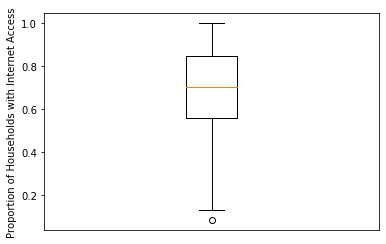

In [26]:
plt.boxplot(internet_proportions["Has Internet"])
plt.ylabel("Proportion of Households with Internet Access")
# xticks are not necessary since there is only one distribution
plt.xticks([])
plt.show()

In [27]:
internet_proportions["Has Internet"].describe()

count    172.000000
mean       0.686202
std        0.187571
min        0.084507
25%        0.556418
50%        0.703812
75%        0.846738
max        1.000000
Name: Has Internet, dtype: float64

The resulting distribution is skewed left meaning that there are many census tracts with a high proportion of households with internet access, and a few census tracts with a low proportion of households with internet access. These census tracts with a low proportion of households with internet access will be of great interest since these are the areas that clearly require improved infrastructure or other support.

Another important step in our analysis is to understand the correlations between all of the variables in consideration. To do so, we will merge all data sets and consider the variables for which we believe there might be a strong correlation.

In [28]:
# inner merge is necessary because there are not observations for the same tracts in each data frame
temp = internet_proportions.merge(race_proportions, how="inner", on="Census Tract")
temp = temp.merge(education_proportions, how="inner", on="Census Tract")
df_all = temp.merge(income, how="inner", on="Census Tract")

We can consider summarize most of the data simply considering the proportion of each tract with no computer and no internet, the proportion of the tract population that is white, the proportion with no high school education, and the median household income in each tract. Considering these variables also allows us to understand the correlations between other variables such as the proportion that does have a computer or internet, the proportion that is non-white, and the proportion with at least a high school diploma because these are all complements of the variables under explicit investigation.

In [29]:
df_all.corr()

,No Internet,Has Internet,White,Non-White,No High School,High School or Above,Median Household Income
No Internet,1.000000,-1.000000,-0.761323,0.761323,0.857278,-0.857278,-0.792468
Has Internet,-1.000000,1.000000,0.761323,-0.761323,-0.857278,0.857278,0.792468
White,-0.761323,0.761323,1.000000,-1.000000,-0.679351,0.679351,0.732181
Non-White,0.761323,-0.761323,-1.000000,1.000000,0.679351,-0.679351,-0.732181
No High School,0.857278,-0.857278,-0.679351,0.679351,1.000000,-1.000000,-0.664614
High School or Above,-0.857278,0.857278,0.679351,-0.679351,-1.000000,1.000000,0.664614
Median Household Income,-0.792468,0.792468,0.732181,-0.732181,-0.664614,0.664614,1.000000


Besides the obvious correlations such as the correlation between having a computer and having internet, this table contains a lot of very valuable information to our investigation. This correlation table indicates strong correlation between the proportion of a census tract with no internet and
- the proportion of the tract that is non-white ($r \approx 0.761$)
- the proportion of the tract that has no high school edution ($r \approx 0.857$)
- the median household income ($r \approx -0.792$)

It will be useful to visualize some of these relationships on a scatter plot:

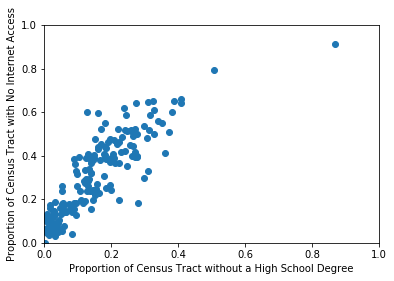

In [30]:
plt.scatter(df_all["No High School"], df_all["No Internet"])
plt.xlabel("Proportion of Census Tract without a High School Degree")
plt.ylabel("Proportion of Census Tract with No Internet Access")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

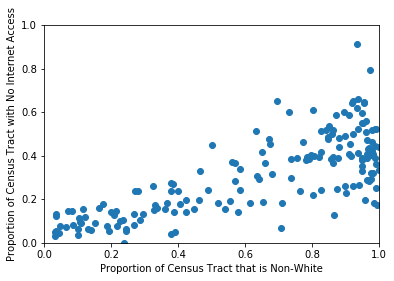

In [31]:
plt.scatter(df_all["Non-White"], df_all["No Internet"])
plt.xlabel("Proportion of Census Tract that is Non-White")
plt.ylabel("Proportion of Census Tract with No Internet Access")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In these plots, each point represents a census tract in Orleans Parish where the y-value is the proportion of the census tract with no internet access. The x-value in the first plot is the proportion of the census tract with no high school degree, and in the second plot the x-value is the proportion of the census tract that is non-white. Both plots allow us to visualize the strong correlations summarized by the correlation matrix.

Now, we want to consider the distribution of publicly accessible internet. To do so, we calculate the distance matrix for all points in this graph, and plot the distances on a heat map.

In [32]:
distances = pairwise_distances(free, metric="euclidean")

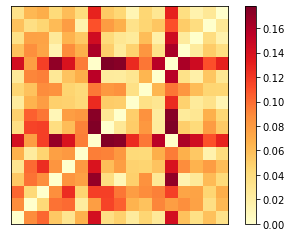

In [33]:
plt.imshow(distances, cmap="YlOrRd", origin="lower")
plt.colorbar()
# ticks are not necessary
plt.xticks([])
plt.yticks([])
plt.show()

In this heat map, each square represents a comparison of one location with publicly accessible internet to another, and the darker the color, the more distant the locations are. Based on this plot, it seems like there are two locations with free internet access far from most others, and the rest of the free internet locations are relatively close to each other.

## Future Directions

For the next part of our project, we plan to test how statistically significant the correlations between internet access and race/education level/income are. We would also like to create a geographic map indicating the proportion of each census tract with access to internet and overlay this data with the locations of publicly accessible internet. If possible, we would like to calculate the distance from each census tract (more specifically, the center of the tract) to its closest publicly accessible internet location. This would allow us to test for correlation between that distance and the proportion of the tract that has access to internet which would inform us as to whether these locations are distributed appropriately.

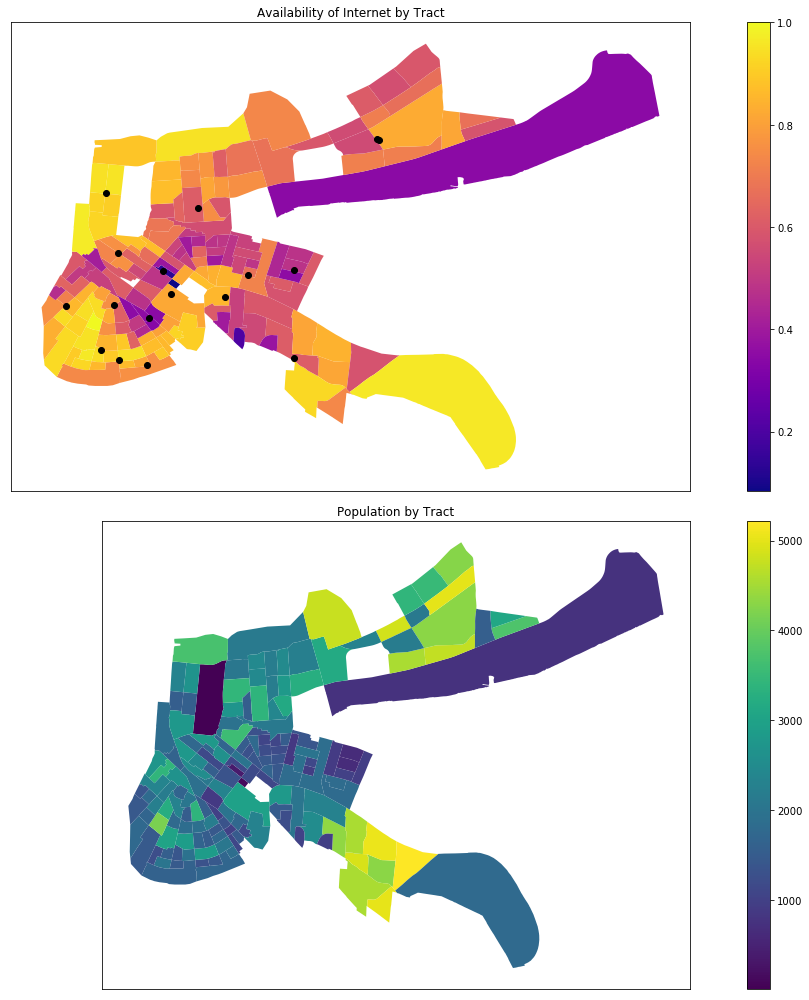

In [213]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,14), tight_layout=True)
ax1.set_title("Availability of Internet by Tract")
ax2.set_title("Population by Tract")
# remove ticks and labels for appearances
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
geo_internet.plot("Has Internet", cmap="plasma", legend=True, ax=ax1)
geo_free.plot(ax=ax1, color="black")
geo_pop.plot("Population", cmap="viridis", legend=True, ax=ax2)